1. Data Preparation
Load the eurlex_resources dataset (DE + EN).

Filter for entries that have versions in both languages.

Perform a Train/Dev/Test split (80/10/10%), ensuring corresponding IDs are kept together in the same set.

2. Model & Pipeline
Select a single bilingual summarizer model (e.g., mt5-small-sum-de-en-v2).

Implement make_summarizer and chunk_and_summarize functions.

3. RAG Index Construction
Create three FAISS indices: one for German chunks (DE-Chunks), one for English chunks (EN-Chunks), and one for multilingual chunks (Multi-Chunks, consisting of parallel-paired DE/EN chunks).

Build a RetrievalQA chain for each of the three indices.

4. Summarization & Demo Check
Test the pipeline on selected examples: German-only, English-only, and multilingual.

Perform a qualitative review and visualization of the outputs.

5. Automated Evaluation
Select a development set with a sufficient number of examples (> 50).

Generate summaries for all three variants (DE-only, EN-only, Multi).

Calculate ROUGE-1, ROUGE-2, ROUGE-L, and BERTScore metrics.

6. Fine-tuning & Optimization
Experiment with prompt tuning, especially for the multi-language prompt.

Adjust chunking parameters, such as chunk size and overlap.

Evaluate different retrieval fusion strategies (e.g., late fusion vs. joint embedding).

7. Human Evaluation (Sample-based)
Assess comprehensibility, completeness, and correctness using a Likert scale.

Supplement the automated metrics with human judgment to get a more holistic view of performance.

8. Documentation & Reporting
Present the final metrics in both tabular format and graphically using boxplots.

In [ ]:
!pip install -U datasets==2.14.6

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 12.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
  Attempting uninstall: dill
    Found existing installation: dill 0.3.8
    Uninstalling dill-0.3.8:
      Successfully uninstalled dill-0.3.8
  Attempting uninstall: multiprocess
    Found existing installation: multiprocess 0.70.16
    Uninstalling multiprocess-0.70.16:
      Successfully uninstalled multiprocess-0.70.16
  Attempting uninstall: datasets
    Found

In [ ]:
#installation
!pip install -q \
  datasets \
  transformers sentencepiece \
  langchain langchain-huggingface langchain-community \
  sentence-transformers faiss-cpu \
  rouge-score bert_score \
  matplotlib tqdm evaluate
import random, re, numpy as np, pandas as pd, matplotlib.pyplot as plt, tqdm
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
from rouge_score import rouge_scorer
from bert_score import score as bert_score
# LangChain
from langchain_huggingface import HuggingFacePipeline
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain.chains import RetrievalQA

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━

In [ ]:
print("Data ")
ds_de = load_dataset("joelniklaus/eurlex_resources", "de_decision", split="train[:10]")
ds_en = load_dataset("joelniklaus/eurlex_resources", "en_decision", split="train[:10]")
text_de = ds_de[0]["text"]
text_en = ds_en[0]["text"]
print("German Example Text:")
print(text_de)
print("\nEnglish Example Text:")
print(text_en)

Data 


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading Dataset Infos from /root/.cache/huggingface/modules/datasets_modules/datasets/joelniklaus--eurlex_resources/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06
INFO:datasets.info:Loading Dataset Infos from /root/.cache/huggingface/modules/datasets_modules/datasets/joelniklaus--eurlex_resources/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06
Generating dataset eurlex_resources (/root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_decision/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06)
INFO:datasets.builder:Generating dataset eurlex_resources (/root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_decision/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06)
INFO:datasets.builder:Downloading and preparing dataset eurlex_resources/de_decision to /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_decision/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4b

https://huggingface.co/datasets/joelito/eurlex_resources/resolve/main/data/de/decision.jsonl.xz not found in cache or force_download set to True, downloading to /root/.cache/huggingface/datasets/downloads/0365c84cbb44dbd119bbb99bb9c8dbbff735bba42b4b60668a27d65f68bdb907.incomplete
INFO:datasets.utils.file_utils:https://huggingface.co/datasets/joelito/eurlex_resources/resolve/main/data/de/decision.jsonl.xz not found in cache or force_download set to True, downloading to /root/.cache/huggingface/datasets/downloads/0365c84cbb44dbd119bbb99bb9c8dbbff735bba42b4b60668a27d65f68bdb907.incomplete


storing https://huggingface.co/datasets/joelito/eurlex_resources/resolve/main/data/de/decision.jsonl.xz in cache at /root/.cache/huggingface/datasets/downloads/0365c84cbb44dbd119bbb99bb9c8dbbff735bba42b4b60668a27d65f68bdb907
INFO:datasets.utils.file_utils:storing https://huggingface.co/datasets/joelito/eurlex_resources/resolve/main/data/de/decision.jsonl.xz in cache at /root/.cache/huggingface/datasets/downloads/0365c84cbb44dbd119bbb99bb9c8dbbff735bba42b4b60668a27d65f68bdb907
creating metadata file for /root/.cache/huggingface/datasets/downloads/0365c84cbb44dbd119bbb99bb9c8dbbff735bba42b4b60668a27d65f68bdb907
INFO:datasets.utils.file_utils:creating metadata file for /root/.cache/huggingface/datasets/downloads/0365c84cbb44dbd119bbb99bb9c8dbbff735bba42b4b60668a27d65f68bdb907
INFO:datasets.download.download_manager:Downloading took 0.0 min
Checksum Computation took 0.0 min
INFO:datasets.download.download_manager:Checksum Computation took 0.0 min
Generating train split
INFO:datasets.builde

Generating train split: 0 examples [00:00, ? examples/s]

Unable to verify splits sizes.
INFO:datasets.utils.info_utils:Unable to verify splits sizes.
Dataset eurlex_resources downloaded and prepared to /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_decision/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06. Subsequent calls will reuse this data.
INFO:datasets.builder:Dataset eurlex_resources downloaded and prepared to /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_decision/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06. Subsequent calls will reuse this data.
https://huggingface.co/datasets/joelniklaus/eurlex_resources/resolve/main/eurlex_resources.py not found in cache or force_download set to True, downloading to /root/.cache/huggingface/datasets/downloads/bf4fa0bf8c20de15782911887389e4eb8acf30d60c224e7e6f0ce170f773c3a5.ff4bbe226e067ea52873f2974d928b4ef614349493d4faf7473a16379c60a1e6.py.incomplete
INFO:datasets.utils.file_utils:https://huggingface.co/data

storing https://huggingface.co/datasets/joelniklaus/eurlex_resources/resolve/main/eurlex_resources.py in cache at /root/.cache/huggingface/datasets/downloads/bf4fa0bf8c20de15782911887389e4eb8acf30d60c224e7e6f0ce170f773c3a5.ff4bbe226e067ea52873f2974d928b4ef614349493d4faf7473a16379c60a1e6.py
INFO:datasets.utils.file_utils:storing https://huggingface.co/datasets/joelniklaus/eurlex_resources/resolve/main/eurlex_resources.py in cache at /root/.cache/huggingface/datasets/downloads/bf4fa0bf8c20de15782911887389e4eb8acf30d60c224e7e6f0ce170f773c3a5.ff4bbe226e067ea52873f2974d928b4ef614349493d4faf7473a16379c60a1e6.py
creating metadata file for /root/.cache/huggingface/datasets/downloads/bf4fa0bf8c20de15782911887389e4eb8acf30d60c224e7e6f0ce170f773c3a5.ff4bbe226e067ea52873f2974d928b4ef614349493d4faf7473a16379c60a1e6.py
INFO:datasets.utils.file_utils:creating metadata file for /root/.cache/huggingface/datasets/downloads/bf4fa0bf8c20de15782911887389e4eb8acf30d60c224e7e6f0ce170f773c3a5.ff4bbe226e067ea5

https://huggingface.co/datasets/joelito/eurlex_resources/resolve/main/data/en/decision.jsonl.xz not found in cache or force_download set to True, downloading to /root/.cache/huggingface/datasets/downloads/7cb9f20b4e09d4f765ef56f2429edb879933f23ddb57846cbdce08d2396b8130.incomplete
INFO:datasets.utils.file_utils:https://huggingface.co/datasets/joelito/eurlex_resources/resolve/main/data/en/decision.jsonl.xz not found in cache or force_download set to True, downloading to /root/.cache/huggingface/datasets/downloads/7cb9f20b4e09d4f765ef56f2429edb879933f23ddb57846cbdce08d2396b8130.incomplete


storing https://huggingface.co/datasets/joelito/eurlex_resources/resolve/main/data/en/decision.jsonl.xz in cache at /root/.cache/huggingface/datasets/downloads/7cb9f20b4e09d4f765ef56f2429edb879933f23ddb57846cbdce08d2396b8130
INFO:datasets.utils.file_utils:storing https://huggingface.co/datasets/joelito/eurlex_resources/resolve/main/data/en/decision.jsonl.xz in cache at /root/.cache/huggingface/datasets/downloads/7cb9f20b4e09d4f765ef56f2429edb879933f23ddb57846cbdce08d2396b8130
creating metadata file for /root/.cache/huggingface/datasets/downloads/7cb9f20b4e09d4f765ef56f2429edb879933f23ddb57846cbdce08d2396b8130
INFO:datasets.utils.file_utils:creating metadata file for /root/.cache/huggingface/datasets/downloads/7cb9f20b4e09d4f765ef56f2429edb879933f23ddb57846cbdce08d2396b8130
INFO:datasets.download.download_manager:Downloading took 0.0 min
Checksum Computation took 0.0 min
INFO:datasets.download.download_manager:Checksum Computation took 0.0 min
Generating train split
INFO:datasets.builde

Generating train split: 0 examples [00:00, ? examples/s]

Unable to verify splits sizes.
INFO:datasets.utils.info_utils:Unable to verify splits sizes.
Dataset eurlex_resources downloaded and prepared to /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_decision/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06. Subsequent calls will reuse this data.
INFO:datasets.builder:Dataset eurlex_resources downloaded and prepared to /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_decision/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06. Subsequent calls will reuse this data.


German Example Text:

   
               14.5.2015   
            
            
               DE
            
            
               Amtsblatt der Europäischen Union
            
            
               L 121/7
            
         BESCHLUSS (EU) 2015/771 DES RATES
   vom 7. Mai 2015
   über den im Namen der Europäischen Union im Gemischten Ausschuss, der mit dem Abkommen zwischen der Europäischen Gemeinschaft und ihren Mitgliedstaaten einerseits und der Schweizerischen Eidgenossenschaft andererseits über die Freizügigkeit eingesetzt wurde, zu vertretenden Standpunkt zur Änderung des Anhangs III (Gegenseitige Anerkennung von Berufsqualifikationen) dieses Abkommens
   DER RAT DER EUROPÄISCHEN UNION —
   gestützt auf den Vertrag über die Arbeitsweise der Europäischen Union, insbesondere auf die Artikel 46, 53 und 62 in Verbindung mit Artikel 218 Absatz 9,
   auf Vorschlag der Europäischen Kommission,
   in Erwägung nachstehender Gründe:
   
               (1)
            
    

In [ ]:
#chunk1
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
from langchain_huggingface import HuggingFacePipeline
from langchain.chains import RetrievalQA
from datasets import load_dataset
from langchain.text_splitter import RecursiveCharacterTextSplitter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DTYPE = torch.float16 if device.type == "cuda" else torch.float32
print(f"Device: {device}")

MODEL_NAME = "T-Systems-onsite/mt5-small-sum-de-en-v2"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
tokenizer.model_max_length = 1024
model = AutoModelForSeq2SeqLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=DTYPE,
    device_map="auto"
)

summarizer = pipeline(
    "text2text-generation",
    model=model,
    tokenizer=tokenizer,
    max_length=120,
    min_length=30,
    no_repeat_ngram_size=3,
    length_penalty=1.5,
    num_beams=4,
    do_sample=False,
    truncation=True,
    device_map="auto"
)

def chunk_text(text: str, tokenizer, chunk_size: int = 1024, chunk_overlap: int = 200):


    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        tokenizer=tokenizer,
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=["\n\n", "\n", " ", ""],
        is_separator_regex=False,
    )

    chunks = text_splitter.split_text(text)
    return chunks



def summarize_text(text: str) -> str:
    parts = []
    for chunk in chunk_text(text, tokenizer, chunk_size=tokenizer.model_max_length):
        parts.append(summarizer(f"summarize:\n{chunk}")[0]["generated_text"])
    if len(parts) > 1:
        merged = " ".join(parts)
        return summarize_text(merged)
    return parts[0]

def summarize_multilingual(text_de: str, text_en: str) -> str:
    sum_de = summarize_text(text_de)
    sum_en = summarize_text(text_en)
    # summaries togather
    return f"DE: {sum_de} EN: {sum_en}"


print("Loading example texts…")
ds_de = load_dataset("joelniklaus/eurlex_resources", "de_decision", split="train[:1]")
ds_en = load_dataset("joelniklaus/eurlex_resources", "en_decision", split="train[:1]")
text_de = ds_de[0]["text"]
text_en = ds_en[0]["text"]


print("\n--- German Chunks (before summarization) ---")
chunks_de = chunk_text(text_de, tokenizer, chunk_size=tokenizer.model_max_length)
for i, chunk in enumerate(chunks_de[:5]):
    print(f"Chunk {i+1}:\n{chunk}\n---")

print("\n--- English Chunks (before summarization) ---")
chunks_en = chunk_text(text_en, tokenizer, chunk_size=tokenizer.model_max_length)
for i, chunk in enumerate(chunks_en[:5]):
    print(f"Chunk {i+1}:\n{chunk}\n---")

print("\nGerman-only Summary:")
print(summarize_text(text_de))

print("\nEnglish-only Summary:")
print(summarize_text(text_en))

print("\nMultilingual Summary:")
sum_multi = summarize_multilingual(text_de, text_en)
print(sum_multi)

Device: cuda


tokenizer_config.json:   0%|          | 0.00/413 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


config.json:   0%|          | 0.00/677 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

Device set to use cuda:0


Loading example texts…


Loading Dataset Infos from /root/.cache/huggingface/modules/datasets_modules/datasets/joelniklaus--eurlex_resources/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06
INFO:datasets.info:Loading Dataset Infos from /root/.cache/huggingface/modules/datasets_modules/datasets/joelniklaus--eurlex_resources/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06
Overwrite dataset info from restored data version if exists.
INFO:datasets.builder:Overwrite dataset info from restored data version if exists.
Loading Dataset info from /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_decision/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06
INFO:datasets.info:Loading Dataset info from /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_decision/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06
Found cached dataset eurlex_resources (/root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_d


--- German Chunks (before summarization) ---
Chunk 1:
14.5.2015   
            
            
               DE
            
            
               Amtsblatt der Europäischen Union
            
            
               L 121/7
            
         BESCHLUSS (EU) 2015/771 DES RATES
   vom 7. Mai 2015
   über den im Namen der Europäischen Union im Gemischten Ausschuss, der mit dem Abkommen zwischen der Europäischen Gemeinschaft und ihren Mitgliedstaaten einerseits und der Schweizerischen Eidgenossenschaft andererseits über die Freizügigkeit eingesetzt wurde, zu vertretenden Standpunkt zur Änderung des Anhangs III (Gegenseitige Anerkennung von Berufsqualifikationen) dieses Abkommens
   DER RAT DER EUROPÄISCHEN UNION —
   gestützt auf den Vertrag über die Arbeitsweise der Europäischen Union, insbesondere auf die Artikel 46, 53 und 62 in Verbindung mit Artikel 218 Absatz 9,
   auf Vorschlag der Europäischen Kommission,
   in Erwägung nachstehender Gründe:
   
               (1)
   

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


DE: Der Präsident des Europäischen Rates, der mit Artikel 14 des Abkommens zwischen der EU und ihren Mitgliedstaaten einerseits und der Schweizerischen Eidgenossenschaft andererseits über die Freizügigkeit eingesetzt wurde, tritt am Tag seiner Annahme in Kraft. EN: The European Commission has published the draft Decision to take into account new legal acts of the European Union and Switzerland since that date . The Agreement was signed on 21 June 1999 and entered into force on 1 June 2002 . It is appropriate to establish the position of the Union within the Joint Committee as regards the amendment of Annex III (Mutual recognition of professional qualifications) to the Agreement .


In [ ]:
import random
import torch
from collections import defaultdict
from datasets import load_dataset
from transformers import AutoTokenizer
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
EMB_MODEL = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
SAMPLE_SIZE = 2000 #
CHUNK_SIZE = 400
OVERLAP = 100
SEED = 42

random.seed(SEED)
ds_de = load_dataset("joelniklaus/eurlex_resources", "de_caselaw", split="train").shuffle(seed=SEED).select(range(SAMPLE_SIZE))
ds_en = load_dataset("joelniklaus/eurlex_resources", "en_caselaw", split="train").shuffle(seed=SEED).select(range(SAMPLE_SIZE))
print(f"Sampled {len(ds_de)} DE docs, {len(ds_en)} EN docs.")

cases = defaultdict(lambda: {"de": None, "en": None, "title": None})
for ex in ds_de:
    cases[ex["celex"]]["de"], cases[ex["celex"]]["title"] = ex["text"], ex["title"]
for ex in ds_en:
    entry = cases[ex["celex"]]
    entry["en"], entry["title"] = ex["text"], entry["title"] or ex["title"]
print(f"Merged cases: {len(cases)}")

mbart_tok = AutoTokenizer.from_pretrained("facebook/mbart-large-50-many-to-many-mmt", use_fast=True)

def strip_head(text):
    return text

def chunk_text(text: str, tokenizer, chunk_size: int = 400, chunk_overlap: int = 100):


    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        tokenizer=tokenizer,
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=["\n\n", "\n", " ", ""],
        is_separator_regex=False,
    )

    chunks = text_splitter.split_text(text)
    return chunks


def build_chunks(split: str):
    texts, metas = [], []
    if split in {"de", "en"}:
        dataset = ds_de if split == "de" else ds_en
        for ex in dataset:
            raw = strip_head(ex["text"])
            for cid, chunk in enumerate(chunk_text(raw, mbart_tok, chunk_size=CHUNK_SIZE, chunk_overlap=OVERLAP)):
                texts.append(chunk)
                metas.append({"celex": ex["celex"], "lang": split, "chunk": cid, "title": ex["title"]})
    else:
        for celex, parts in cases.items():
            if parts["de"] or parts["en"]:
                de_chunks = chunk_text(strip_head(parts["de"]) if parts["de"] else "", mbart_tok, chunk_size=CHUNK_SIZE, chunk_overlap=OVERLAP)
                en_chunks = chunk_text(strip_head(parts["en"]) if parts["en"] else "", mbart_tok, chunk_size=CHUNK_SIZE, chunk_overlap=OVERLAP)


                max_chunks = max(len(de_chunks), len(en_chunks))
                for i in range(max_chunks):
                    multi_chunk = ""
                    if i < len(de_chunks):
                        multi_chunk += f"DE: {de_chunks[i]}"
                    if i < len(en_chunks):
                        if multi_chunk:
                            multi_chunk += " EN: "
                        else:
                             multi_chunk += "EN: "
                        multi_chunk += en_chunks[i]

                    if multi_chunk: # nur  non-empty chunks
                         texts.append(multi_chunk)
                         metas.append({"celex": celex, "lang": "multi", "chunk": i, "title": parts["title"]})

    return texts, metas

def get_embedder():
    try:
        if torch.cuda.is_available():
            print("Loading embeddings on GPU…")
            return HuggingFaceEmbeddings(model_name=EMB_MODEL, model_kwargs={"device": "cuda"})
        raise RuntimeError("GPU not available")
    except Exception:
        print("Falling back to CPU embeddings…")
        return HuggingFaceEmbeddings(model_name=EMB_MODEL, model_kwargs={"device": "cpu"})

embedder = get_embedder()

retrievers = {}
for split in ["de", "en", "multi"]:
    texts, metas = build_chunks(split)
    valid_texts_metas = [(t, m) for t, m in zip(texts, metas) if t.strip()]
    valid_texts, valid_metas = zip(*valid_texts_metas) if valid_texts_metas else ([], [])

    if valid_texts:
        db = FAISS.from_texts(list(valid_texts), embedder, metadatas=list(valid_metas))
        retrievers[split] = db.as_retriever(search_kwargs={"k": 6})
        print(f"{split.upper()}: {len(valid_texts)} chunks")
    else:
        print(f"{split.upper()}: No valid chunks to build index.")
        retrievers[split] = None


print("Retrievers ready: retrievers['de'], retrievers['en'], retrievers['multi']")

Loading Dataset Infos from /root/.cache/huggingface/modules/datasets_modules/datasets/joelniklaus--eurlex_resources/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06
INFO:datasets.info:Loading Dataset Infos from /root/.cache/huggingface/modules/datasets_modules/datasets/joelniklaus--eurlex_resources/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06
Generating dataset eurlex_resources (/root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06)
INFO:datasets.builder:Generating dataset eurlex_resources (/root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06)
INFO:datasets.builder:Downloading and preparing dataset eurlex_resources/de_caselaw to /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7

https://huggingface.co/datasets/joelito/eurlex_resources/resolve/main/data/de/caselaw.jsonl.xz not found in cache or force_download set to True, downloading to /root/.cache/huggingface/datasets/downloads/dc6e04dde1df1329756d563bae0b4c3abcde0e1d76740452285fefddf9272c0f.incomplete
INFO:datasets.utils.file_utils:https://huggingface.co/datasets/joelito/eurlex_resources/resolve/main/data/de/caselaw.jsonl.xz not found in cache or force_download set to True, downloading to /root/.cache/huggingface/datasets/downloads/dc6e04dde1df1329756d563bae0b4c3abcde0e1d76740452285fefddf9272c0f.incomplete


storing https://huggingface.co/datasets/joelito/eurlex_resources/resolve/main/data/de/caselaw.jsonl.xz in cache at /root/.cache/huggingface/datasets/downloads/dc6e04dde1df1329756d563bae0b4c3abcde0e1d76740452285fefddf9272c0f
INFO:datasets.utils.file_utils:storing https://huggingface.co/datasets/joelito/eurlex_resources/resolve/main/data/de/caselaw.jsonl.xz in cache at /root/.cache/huggingface/datasets/downloads/dc6e04dde1df1329756d563bae0b4c3abcde0e1d76740452285fefddf9272c0f
creating metadata file for /root/.cache/huggingface/datasets/downloads/dc6e04dde1df1329756d563bae0b4c3abcde0e1d76740452285fefddf9272c0f
INFO:datasets.utils.file_utils:creating metadata file for /root/.cache/huggingface/datasets/downloads/dc6e04dde1df1329756d563bae0b4c3abcde0e1d76740452285fefddf9272c0f
INFO:datasets.download.download_manager:Downloading took 0.0 min
Checksum Computation took 0.0 min
INFO:datasets.download.download_manager:Checksum Computation took 0.0 min
Generating train split
INFO:datasets.builder:

Generating train split: 0 examples [00:00, ? examples/s]

Unable to verify splits sizes.
INFO:datasets.utils.info_utils:Unable to verify splits sizes.
Dataset eurlex_resources downloaded and prepared to /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06. Subsequent calls will reuse this data.
INFO:datasets.builder:Dataset eurlex_resources downloaded and prepared to /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06. Subsequent calls will reuse this data.
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)
Caching indices mapping at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-36d44046923b41e0.arrow
INFO:datasets.arrow_da

https://huggingface.co/datasets/joelito/eurlex_resources/resolve/main/data/en/caselaw.jsonl.xz not found in cache or force_download set to True, downloading to /root/.cache/huggingface/datasets/downloads/d6268a51e0533986d540b3ca2bf20ff96561071ff94b6ec9031d13f7ba05a05d.incomplete
INFO:datasets.utils.file_utils:https://huggingface.co/datasets/joelito/eurlex_resources/resolve/main/data/en/caselaw.jsonl.xz not found in cache or force_download set to True, downloading to /root/.cache/huggingface/datasets/downloads/d6268a51e0533986d540b3ca2bf20ff96561071ff94b6ec9031d13f7ba05a05d.incomplete


storing https://huggingface.co/datasets/joelito/eurlex_resources/resolve/main/data/en/caselaw.jsonl.xz in cache at /root/.cache/huggingface/datasets/downloads/d6268a51e0533986d540b3ca2bf20ff96561071ff94b6ec9031d13f7ba05a05d
INFO:datasets.utils.file_utils:storing https://huggingface.co/datasets/joelito/eurlex_resources/resolve/main/data/en/caselaw.jsonl.xz in cache at /root/.cache/huggingface/datasets/downloads/d6268a51e0533986d540b3ca2bf20ff96561071ff94b6ec9031d13f7ba05a05d
creating metadata file for /root/.cache/huggingface/datasets/downloads/d6268a51e0533986d540b3ca2bf20ff96561071ff94b6ec9031d13f7ba05a05d
INFO:datasets.utils.file_utils:creating metadata file for /root/.cache/huggingface/datasets/downloads/d6268a51e0533986d540b3ca2bf20ff96561071ff94b6ec9031d13f7ba05a05d
INFO:datasets.download.download_manager:Downloading took 0.0 min
Checksum Computation took 0.0 min
INFO:datasets.download.download_manager:Checksum Computation took 0.0 min
Generating train split
INFO:datasets.builder:

Generating train split: 0 examples [00:00, ? examples/s]

Unable to verify splits sizes.
INFO:datasets.utils.info_utils:Unable to verify splits sizes.
Dataset eurlex_resources downloaded and prepared to /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06. Subsequent calls will reuse this data.
INFO:datasets.builder:Dataset eurlex_resources downloaded and prepared to /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06. Subsequent calls will reuse this data.
Caching indices mapping at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-75cb21957e9b1624.arrow
INFO:datasets.arrow_dataset:Caching indices mapping at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/ca

Sampled 2000 DE docs, 2000 EN docs.
Merged cases: 3807


tokenizer_config.json:   0%|          | 0.00/529 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/649 [00:00<?, ?B/s]

Loading embeddings on GPU…


/tmp/ipython-input-2472669096.py:89: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  return HuggingFaceEmbeddings(model_name=EMB_MODEL, model_kwargs={"device": "cuda"})


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


DE: 23231 chunks
EN: 22076 chunks
MULTI: 44193 chunks
Retrievers ready: retrievers['de'], retrievers['en'], retrievers['multi']


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
from langchain_huggingface import HuggingFacePipeline
from langchain.chains import RetrievalQA

device = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_NAME = "T-Systems-onsite/mt5-small-sum-de-en-v2"
DTYPE = torch.float16 if device == "cuda" else torch.float32

print("Initializing multilingual summarizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME, torch_dtype=DTYPE, device_map="auto")
summarizer = pipeline(
    "text2text-generation",
    model=model,
    tokenizer=tokenizer,
    max_length=160,
    min_length=40,
    no_repeat_ngram_size=3,
    length_penalty=1.5,
    num_beams=4,
    do_sample=False,
    truncation=True,
    device_map="auto"
)
llm = HuggingFacePipeline(pipeline=summarizer)

if 'retrievers' not in globals():
    raise RuntimeError("`retrievers` dict not found – run FAISS indexing first.")

#RAG QA chains
dag_types = ['de', 'en', 'multi']
rag_chains = {}
for split in dag_types:
    retriever = retrievers[split]
    rag = RetrievalQA.from_chain_type(
        llm=llm,
        retriever=retriever,
        chain_type="map_reduce",
        return_source_documents=False
    )
    rag_chains[split] = rag
    print(f"RAG-{split.upper()} chain ready.")

# query (DE)
query = "Was ist die Pflicht der Behörden des Vereinigten Königreichs laut EuGH-Urteil?"
print("\nDE-RAG answer:")
print(rag_chains['de'](query))

# query (EN)
query_en = "What duty do UK authorities have according to the ECJ judgment?"
print("\nEN-RAG answer:")
print(rag_chains['en'](query_en))

#  query (Multi)
print("\nMULTI-RAG answer (DE target):")
print(rag_chains['multi'](query))


Initializing multilingual summarizer...


/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Device set to use cuda:0
/tmp/ipython-input-3206348816.py:48: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  print(rag_chains['de'](query))


RAG-DE chain ready.
RAG-EN chain ready.
RAG-MULTI chain ready.

DE-RAG answer:


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (2216 > 1024). Running this sequence through the model will result in indexing errors


{'query': 'Was ist die Pflicht der Behörden des Vereinigten Königreichs laut EuGH-Urteil?', 'result': 'The Urteil des Bundesgerichtshofs erster Instanz der Europäischen Güterkraftverkehr und Logistik eV gegen Bundesrepublik Gemeinschaften vom 29. November 2000 zeigt: Was ist die Pflicht der Behörden des Vereinigten Königreichs laut EuGH-Urteil?'}

EN-RAG answer:


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'query': 'What duty do UK authorities have according to the ECJ judgment?', 'result': "This Agreement is governed by English law and the parties submit to the exclusive jurisdiction of the English courts in relation to any dispute (contractual or non-contractual) concerning this Agreement save that either party may apply to any court for an injunction or other relief to protect its Intellectual Property Rights . The European Court of Justice has ordered a review of the UK's rules on the infringement of British chemicals and Chemicals following a judgement in which it was ordered by the European Commission ."}

MULTI-RAG answer (DE target):


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'query': 'Was ist die Pflicht der Behörden des Vereinigten Königreichs laut EuGH-Urteil?', 'result': 'Was ist die Pflicht der Behörden des Vereinigten Königreichs laut EuGH-Urteil laut einem englischen Recht laut, wenn ich es recht sehe, einen strengeren Standpunkt als das Recht mancher anderer Vertragsstaaten ein, nach dem nicht notwendigerweise allein davon auszugehen ist.'}


In [ ]:
!pip install -q evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.5 MB/s eta 0:00:00


In [ ]:
%env PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

env: PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True


Loading Dataset Infos from /root/.cache/huggingface/modules/datasets_modules/datasets/joelniklaus--eurlex_resources/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06
INFO:datasets.info:Loading Dataset Infos from /root/.cache/huggingface/modules/datasets_modules/datasets/joelniklaus--eurlex_resources/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06
Overwrite dataset info from restored data version if exists.
INFO:datasets.builder:Overwrite dataset info from restored data version if exists.
Loading Dataset info from /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06
INFO:datasets.info:Loading Dataset info from /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06
Found cached dataset eurlex_resources (/root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_cas


Comparision 
Evaluating 50 samples with both DE and EN texts.

Sample 1 (CELEX: C1999/174/29): DE length 4562, EN length 4343


Filter:   0%|          | 0/104228 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-ddd0a6206aa8a6ea.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-ddd0a6206aa8a6ea.arrow


Filter:   0%|          | 0/104422 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-de1fc286c5b2c98a.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-de1fc286c5b2c98a.arrow
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


DE   ROUGE-1=0.286  ROUGE-L=0.286  BERT-F1=0.740
Evaluating EN-only vs EN reference...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


EN   ROUGE-1=0.302  ROUGE-L=0.302  BERT-F1=0.867
Evaluating MULTI vs Combined Multi reference...
MULTI (vs Combined Ref) ROUGE-1=0.326  ROUGE-L=0.326  BERT-F1=0.845

Sample 2 (CELEX: C2000/302/45): DE length 3668, EN length 4168


Filter:   0%|          | 0/104228 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-17dfbe399e2e8459.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-17dfbe399e2e8459.arrow


Filter:   0%|          | 0/104422 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-6a4ca2eab271c249.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-6a4ca2eab271c249.arrow


DE   ROUGE-1=0.186  ROUGE-L=0.186  BERT-F1=0.767
Evaluating EN-only vs EN reference...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EN   ROUGE-1=0.410  ROUGE-L=0.410  BERT-F1=0.869
Evaluating MULTI vs Combined Multi reference...
MULTI (vs Combined Ref) ROUGE-1=0.326  ROUGE-L=0.326  BERT-F1=0.858

Sample 3 (CELEX: C2003/124/22): DE length 6130, EN length 5780


Filter:   0%|          | 0/104228 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-8e1b8c71cfc587d5.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-8e1b8c71cfc587d5.arrow


Filter:   0%|          | 0/104422 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-867a7286489beffa.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-867a7286489beffa.arrow


DE   ROUGE-1=0.435  ROUGE-L=0.290  BERT-F1=0.704
Evaluating EN-only vs EN reference...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EN   ROUGE-1=0.340  ROUGE-L=0.280  BERT-F1=0.859
Evaluating MULTI vs Combined Multi reference...
MULTI (vs Combined Ref) ROUGE-1=0.405  ROUGE-L=0.301  BERT-F1=0.842

Sample 4 (CELEX: C2006/086/52): DE length 1909, EN length 1869


Filter:   0%|          | 0/104228 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-4cbc7e318581aa67.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-4cbc7e318581aa67.arrow


Filter:   0%|          | 0/104422 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-5fdcc2cefdde548b.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-5fdcc2cefdde548b.arrow


DE   ROUGE-1=0.212  ROUGE-L=0.192  BERT-F1=0.692
Evaluating EN-only vs EN reference...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EN   ROUGE-1=0.360  ROUGE-L=0.288  BERT-F1=0.840
Evaluating MULTI vs Combined Multi reference...
MULTI (vs Combined Ref) ROUGE-1=0.311  ROUGE-L=0.256  BERT-F1=0.821

Sample 5 (CELEX: 62017TN0001): DE length 1935, EN length 1951


Filter:   0%|          | 0/104228 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-776c85aa3292a7b9.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-776c85aa3292a7b9.arrow


Filter:   0%|          | 0/104422 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-3a8b23fef5bcb091.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-3a8b23fef5bcb091.arrow


DE   ROUGE-1=0.128  ROUGE-L=0.128  BERT-F1=0.632
Evaluating EN-only vs EN reference...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EN   ROUGE-1=0.273  ROUGE-L=0.212  BERT-F1=0.847
Evaluating MULTI vs Combined Multi reference...
MULTI (vs Combined Ref) ROUGE-1=0.256  ROUGE-L=0.222  BERT-F1=0.814

Sample 6 (CELEX: C2006/294/34): DE length 1740, EN length 1598


Filter:   0%|          | 0/104228 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-499e0089325c3475.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-499e0089325c3475.arrow


Filter:   0%|          | 0/104422 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-c864478ea8005f36.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-c864478ea8005f36.arrow


DE   ROUGE-1=0.405  ROUGE-L=0.378  BERT-F1=0.728
Evaluating EN-only vs EN reference...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EN   ROUGE-1=0.720  ROUGE-L=0.560  BERT-F1=0.913
Evaluating MULTI vs Combined Multi reference...
MULTI (vs Combined Ref) ROUGE-1=0.575  ROUGE-L=0.484  BERT-F1=0.872

Sample 7 (CELEX: 62017TN0118): DE length 4746, EN length 4571


Filter:   0%|          | 0/104228 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-2b65de35b5efc50b.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-2b65de35b5efc50b.arrow


Filter:   0%|          | 0/104422 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-515fbee1d11a8243.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-515fbee1d11a8243.arrow


DE   ROUGE-1=0.194  ROUGE-L=0.129  BERT-F1=0.662
Evaluating EN-only vs EN reference...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EN   ROUGE-1=0.118  ROUGE-L=0.088  BERT-F1=0.825
Evaluating MULTI vs Combined Multi reference...
MULTI (vs Combined Ref) ROUGE-1=0.209  ROUGE-L=0.134  BERT-F1=0.803

Sample 8 (CELEX: C2002/144/53): DE length 2998, EN length 2727


Filter:   0%|          | 0/104228 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-e77c7ce9bbbee1b9.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-e77c7ce9bbbee1b9.arrow


Filter:   0%|          | 0/104422 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-8c97d63aca4630bb.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-8c97d63aca4630bb.arrow


DE   ROUGE-1=0.323  ROUGE-L=0.323  BERT-F1=0.751
Evaluating EN-only vs EN reference...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EN   ROUGE-1=0.439  ROUGE-L=0.439  BERT-F1=0.873
Evaluating MULTI vs Combined Multi reference...
MULTI (vs Combined Ref) ROUGE-1=0.421  ROUGE-L=0.421  BERT-F1=0.862

Sample 9 (CELEX: 62008CA0229): DE length 2170, EN length 2019


Filter:   0%|          | 0/104228 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-00ed8643747bed4b.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-00ed8643747bed4b.arrow


Filter:   0%|          | 0/104422 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-cbbb876389ef1a26.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-cbbb876389ef1a26.arrow


DE   ROUGE-1=0.466  ROUGE-L=0.427  BERT-F1=0.726
Evaluating EN-only vs EN reference...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EN   ROUGE-1=0.475  ROUGE-L=0.344  BERT-F1=0.849
Evaluating MULTI vs Combined Multi reference...
MULTI (vs Combined Ref) ROUGE-1=0.480  ROUGE-L=0.393  BERT-F1=0.852

Sample 10 (CELEX: 62009FA0047): DE length 1546, EN length 1568


Filter:   0%|          | 0/104228 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-4d28169ef607783c.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-4d28169ef607783c.arrow


Filter:   0%|          | 0/104422 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-b738cf99f4363ffc.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-b738cf99f4363ffc.arrow


DE   ROUGE-1=0.280  ROUGE-L=0.172  BERT-F1=0.654
Evaluating EN-only vs EN reference...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EN   ROUGE-1=0.330  ROUGE-L=0.268  BERT-F1=0.828
Evaluating MULTI vs Combined Multi reference...
MULTI (vs Combined Ref) ROUGE-1=0.330  ROUGE-L=0.237  BERT-F1=0.809

Sample 11 (CELEX: 62013CA0649): DE length 3544, EN length 3506


Filter:   0%|          | 0/104228 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-8419a83d5b7ef7a2.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-8419a83d5b7ef7a2.arrow


Filter:   0%|          | 0/104422 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-b1cdba56dd000c1c.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-b1cdba56dd000c1c.arrow


DE   ROUGE-1=0.206  ROUGE-L=0.158  BERT-F1=0.662
Evaluating EN-only vs EN reference...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EN   ROUGE-1=0.476  ROUGE-L=0.233  BERT-F1=0.864
Evaluating MULTI vs Combined Multi reference...
MULTI (vs Combined Ref) ROUGE-1=0.363  ROUGE-L=0.208  BERT-F1=0.818

Sample 12 (CELEX: 62006TB0157(01)): DE length 532, EN length 545


Filter:   0%|          | 0/104228 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-449fe28e2f39af5b.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-449fe28e2f39af5b.arrow


Filter:   0%|          | 0/104422 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-e141fcc40060b33c.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-e141fcc40060b33c.arrow


DE   ROUGE-1=0.091  ROUGE-L=0.091  BERT-F1=0.631
Evaluating EN-only vs EN reference...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EN   ROUGE-1=0.464  ROUGE-L=0.393  BERT-F1=0.853
Evaluating MULTI vs Combined Multi reference...
MULTI (vs Combined Ref) ROUGE-1=0.327  ROUGE-L=0.288  BERT-F1=0.821

Sample 13 (CELEX: C2003/124/07): DE length 6977, EN length 7128


Filter:   0%|          | 0/104228 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-ca8ffa63b7b8d007.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-ca8ffa63b7b8d007.arrow


Filter:   0%|          | 0/104422 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-4ee4ace26494dec1.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-4ee4ace26494dec1.arrow


DE   ROUGE-1=0.161  ROUGE-L=0.097  BERT-F1=0.635
Evaluating EN-only vs EN reference...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EN   ROUGE-1=0.252  ROUGE-L=0.252  BERT-F1=0.832
Evaluating MULTI vs Combined Multi reference...
MULTI (vs Combined Ref) ROUGE-1=0.237  ROUGE-L=0.213  BERT-F1=0.811

Sample 14 (CELEX: C2007/269/30): DE length 2341, EN length 2220


Filter:   0%|          | 0/104228 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-b9a979adb7150120.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-b9a979adb7150120.arrow


Filter:   0%|          | 0/104422 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-1b72620f61473943.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-1b72620f61473943.arrow


DE   ROUGE-1=0.396  ROUGE-L=0.312  BERT-F1=0.703
Evaluating EN-only vs EN reference...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EN   ROUGE-1=0.426  ROUGE-L=0.319  BERT-F1=0.843
Evaluating MULTI vs Combined Multi reference...
MULTI (vs Combined Ref) ROUGE-1=0.423  ROUGE-L=0.330  BERT-F1=0.818

Sample 15 (CELEX: 62009TJ0509): DE length 86162, EN length 80899


Filter:   0%|          | 0/104228 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-7d92cd3e7f403faa.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-7d92cd3e7f403faa.arrow


Filter:   0%|          | 0/104422 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-e31bfe0782b8bcc4.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-e31bfe0782b8bcc4.arrow


Summarization failed for sample 15: CUDA out of memory. Tried to allocate 1.32 GiB. GPU 0 has a total capacity of 14.74 GiB of which 866.12 MiB is free. Process 10175 has 13.89 GiB memory in use. Of the allocated memory 13.28 GiB is allocated by PyTorch, and 500.43 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Sample 16 (CELEX: 62009CA0274): DE length 3001, EN length 2811


Filter:   0%|          | 0/104228 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-51a641fecc670a4a.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-51a641fecc670a4a.arrow


Filter:   0%|          | 0/104422 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-1d901b7d590420e7.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-1d901b7d590420e7.arrow


DE   ROUGE-1=0.243  ROUGE-L=0.168  BERT-F1=0.663
Evaluating EN-only vs EN reference...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EN   ROUGE-1=0.575  ROUGE-L=0.550  BERT-F1=0.914
Evaluating MULTI vs Combined Multi reference...
MULTI (vs Combined Ref) ROUGE-1=0.398  ROUGE-L=0.346  BERT-F1=0.853

Sample 17 (CELEX: 62018TN0428): DE length 1953, EN length 1974


Filter:   0%|          | 0/104228 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-4ab8f873b615f1ce.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-4ab8f873b615f1ce.arrow


Filter:   0%|          | 0/104422 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-41454573464ed3ed.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-41454573464ed3ed.arrow


DE   ROUGE-1=0.167  ROUGE-L=0.167  BERT-F1=0.652
Evaluating EN-only vs EN reference...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EN   ROUGE-1=0.255  ROUGE-L=0.218  BERT-F1=0.831
Evaluating MULTI vs Combined Multi reference...
MULTI (vs Combined Ref) ROUGE-1=0.243  ROUGE-L=0.224  BERT-F1=0.822

Sample 18 (CELEX: 62010TA0216): DE length 1881, EN length 1884


Filter:   0%|          | 0/104228 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-93b628d30a4e1b09.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-93b628d30a4e1b09.arrow


Filter:   0%|          | 0/104422 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-4d669126051aebdf.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-4d669126051aebdf.arrow


DE   ROUGE-1=0.396  ROUGE-L=0.330  BERT-F1=0.673
Evaluating EN-only vs EN reference...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EN   ROUGE-1=0.442  ROUGE-L=0.250  BERT-F1=0.847
Evaluating MULTI vs Combined Multi reference...
MULTI (vs Combined Ref) ROUGE-1=0.432  ROUGE-L=0.302  BERT-F1=0.815

Sample 19 (CELEX: C1999/226/04): DE length 5935, EN length 6331


Filter:   0%|          | 0/104228 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-1d5236758f95cf68.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-1d5236758f95cf68.arrow


Filter:   0%|          | 0/104422 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-38f68d1334c86aba.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-38f68d1334c86aba.arrow


DE   ROUGE-1=0.337  ROUGE-L=0.217  BERT-F1=0.682
Evaluating EN-only vs EN reference...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EN   ROUGE-1=0.301  ROUGE-L=0.215  BERT-F1=0.823
Evaluating MULTI vs Combined Multi reference...
MULTI (vs Combined Ref) ROUGE-1=0.333  ROUGE-L=0.233  BERT-F1=0.825

Sample 20 (CELEX: 62012TN0229): DE length 2422, EN length 2290


Filter:   0%|          | 0/104228 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-756cc0f8ad54d5c5.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-756cc0f8ad54d5c5.arrow


Filter:   0%|          | 0/104422 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-3f8344bfac4843ab.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-3f8344bfac4843ab.arrow


DE   ROUGE-1=0.182  ROUGE-L=0.182  BERT-F1=0.627
Evaluating EN-only vs EN reference...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EN   ROUGE-1=0.167  ROUGE-L=0.167  BERT-F1=0.821
Evaluating MULTI vs Combined Multi reference...
MULTI (vs Combined Ref) ROUGE-1=0.208  ROUGE-L=0.208  BERT-F1=0.801

Sample 21 (CELEX: 61993TO0468): DE length 20033, EN length 20176


Filter:   0%|          | 0/104228 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-0690c4d5bce0bc8f.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-0690c4d5bce0bc8f.arrow


Filter:   0%|          | 0/104422 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-1f3ce2ce030ca707.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-1f3ce2ce030ca707.arrow


DE   ROUGE-1=0.184  ROUGE-L=0.138  BERT-F1=0.681
Evaluating EN-only vs EN reference...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EN   ROUGE-1=0.416  ROUGE-L=0.297  BERT-F1=0.849
Evaluating MULTI vs Combined Multi reference...
MULTI (vs Combined Ref) ROUGE-1=0.323  ROUGE-L=0.240  BERT-F1=0.832

Sample 22 (CELEX: C1997/040/23): DE length 15236, EN length 15068


Filter:   0%|          | 0/104228 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-fac29e4ae553c89e.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-fac29e4ae553c89e.arrow


Filter:   0%|          | 0/104422 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-e45e4947b52b557a.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-e45e4947b52b557a.arrow


DE   ROUGE-1=0.073  ROUGE-L=0.036  BERT-F1=0.624
Evaluating EN-only vs EN reference...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EN   ROUGE-1=0.262  ROUGE-L=0.119  BERT-F1=0.811
Evaluating MULTI vs Combined Multi reference...
MULTI (vs Combined Ref) ROUGE-1=0.210  ROUGE-L=0.112  BERT-F1=0.788

Sample 23 (CELEX: C2000/335/56): DE length 6953, EN length 6756


Filter:   0%|          | 0/104228 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-5bd22bcd0531b7e2.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-5bd22bcd0531b7e2.arrow


Filter:   0%|          | 0/104422 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-816b6bd618c592d0.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-816b6bd618c592d0.arrow


DE   ROUGE-1=0.000  ROUGE-L=0.000  BERT-F1=0.626
Evaluating EN-only vs EN reference...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EN   ROUGE-1=0.133  ROUGE-L=0.133  BERT-F1=0.788
Evaluating MULTI vs Combined Multi reference...
MULTI (vs Combined Ref) ROUGE-1=0.134  ROUGE-L=0.107  BERT-F1=0.782

Sample 24 (CELEX: C2000/034/51): DE length 6045, EN length 5439


Filter:   0%|          | 0/104228 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-389788919697ff2d.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-389788919697ff2d.arrow


Filter:   0%|          | 0/104422 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-581a664fc3a593cb.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-581a664fc3a593cb.arrow


DE   ROUGE-1=0.404  ROUGE-L=0.202  BERT-F1=0.667
Evaluating EN-only vs EN reference...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EN   ROUGE-1=0.382  ROUGE-L=0.247  BERT-F1=0.835
Evaluating MULTI vs Combined Multi reference...
MULTI (vs Combined Ref) ROUGE-1=0.407  ROUGE-L=0.253  BERT-F1=0.812

Sample 25 (CELEX: 62015CN0239): DE length 4032, EN length 3652


Filter:   0%|          | 0/104228 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-bfc5e33eba4d560c.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-bfc5e33eba4d560c.arrow


Filter:   0%|          | 0/104422 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-ed750cf209b25402.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-ed750cf209b25402.arrow


DE   ROUGE-1=0.152  ROUGE-L=0.091  BERT-F1=0.639
Evaluating EN-only vs EN reference...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EN   ROUGE-1=0.659  ROUGE-L=0.659  BERT-F1=0.913
Evaluating MULTI vs Combined Multi reference...
MULTI (vs Combined Ref) ROUGE-1=0.456  ROUGE-L=0.430  BERT-F1=0.865

Sample 26 (CELEX: 62013CN0531): DE length 3429, EN length 3636


Filter:   0%|          | 0/104228 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-aba262fb4df3df49.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-aba262fb4df3df49.arrow


Filter:   0%|          | 0/104422 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-e1baa0ba40259be5.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-e1baa0ba40259be5.arrow


DE   ROUGE-1=0.024  ROUGE-L=0.024  BERT-F1=0.624
Evaluating EN-only vs EN reference...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EN   ROUGE-1=0.406  ROUGE-L=0.406  BERT-F1=0.879
Evaluating MULTI vs Combined Multi reference...
MULTI (vs Combined Ref) ROUGE-1=0.213  ROUGE-L=0.213  BERT-F1=0.801

Sample 27 (CELEX: 62019CC0724): DE length 47625, EN length 45594


Filter:   0%|          | 0/104228 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-612e0074b8f69e38.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-612e0074b8f69e38.arrow


Filter:   0%|          | 0/104422 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-e6108690f1816fbd.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-e6108690f1816fbd.arrow


Skipping DE-only evaluation for sample 27 due to missing reference or failed summarization.
Evaluating EN-only vs EN reference...
Skipping EN-only evaluation for sample 27 due to missing reference or failed summarization.
Evaluating MULTI vs Combined Multi reference...
MULTI (vs Combined Ref) ROUGE-1=0.037  ROUGE-L=0.037  BERT-F1=0.766

Sample 28 (CELEX: 62014FB0069): DE length 528, EN length 517


Filter:   0%|          | 0/104228 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-3e2342e80678ec52.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-3e2342e80678ec52.arrow


Filter:   0%|          | 0/104422 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-11acff2c4de483d1.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-11acff2c4de483d1.arrow


DE   ROUGE-1=0.136  ROUGE-L=0.136  BERT-F1=0.659
Evaluating EN-only vs EN reference...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EN   ROUGE-1=0.511  ROUGE-L=0.468  BERT-F1=0.870
Evaluating MULTI vs Combined Multi reference...
MULTI (vs Combined Ref) ROUGE-1=0.358  ROUGE-L=0.337  BERT-F1=0.851

Sample 29 (CELEX: 62008CN0503): DE length 1428, EN length 1329


Filter:   0%|          | 0/104228 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-5f9fffa7d6a2864f.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-5f9fffa7d6a2864f.arrow


Filter:   0%|          | 0/104422 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-9b43fc8110fce781.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-9b43fc8110fce781.arrow


DE   ROUGE-1=0.295  ROUGE-L=0.262  BERT-F1=0.717
Evaluating EN-only vs EN reference...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EN   ROUGE-1=0.333  ROUGE-L=0.300  BERT-F1=0.852
Evaluating MULTI vs Combined Multi reference...
MULTI (vs Combined Ref) ROUGE-1=0.336  ROUGE-L=0.304  BERT-F1=0.854

Sample 30 (CELEX: C2003/275/68): DE length 3720, EN length 3603


Filter:   0%|          | 0/104228 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-001c8fd215b99cb4.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-001c8fd215b99cb4.arrow


Filter:   0%|          | 0/104422 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-80580892e28bf091.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-80580892e28bf091.arrow


DE   ROUGE-1=0.618  ROUGE-L=0.473  BERT-F1=0.793
Evaluating EN-only vs EN reference...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EN   ROUGE-1=0.523  ROUGE-L=0.523  BERT-F1=0.886
Evaluating MULTI vs Combined Multi reference...
MULTI (vs Combined Ref) ROUGE-1=0.581  ROUGE-L=0.516  BERT-F1=0.895

Sample 31 (CELEX: C1995/229/06): DE length 7209, EN length 6954


Filter:   0%|          | 0/104228 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-7cc0ebedf562c08b.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-7cc0ebedf562c08b.arrow


Filter:   0%|          | 0/104422 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-3e3ab3e5a075f1c3.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-3e3ab3e5a075f1c3.arrow


DE   ROUGE-1=0.333  ROUGE-L=0.271  BERT-F1=0.731
Evaluating EN-only vs EN reference...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EN   ROUGE-1=0.388  ROUGE-L=0.245  BERT-F1=0.841
Evaluating MULTI vs Combined Multi reference...
MULTI (vs Combined Ref) ROUGE-1=0.384  ROUGE-L=0.273  BERT-F1=0.830

Sample 32 (CELEX: 61963CC0084): DE length 14455, EN length 12861


Filter:   0%|          | 0/104228 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-a7393824ea27e25a.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-a7393824ea27e25a.arrow


Filter:   0%|          | 0/104422 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-b1e0d8ebb345f722.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-b1e0d8ebb345f722.arrow


DE   ROUGE-1=0.179  ROUGE-L=0.179  BERT-F1=0.646
Evaluating EN-only vs EN reference...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EN   ROUGE-1=0.239  ROUGE-L=0.174  BERT-F1=0.834
Evaluating MULTI vs Combined Multi reference...
MULTI (vs Combined Ref) ROUGE-1=0.237  ROUGE-L=0.197  BERT-F1=0.815

Sample 33 (CELEX: 62012CN0462): DE length 5321, EN length 5279


Filter:   0%|          | 0/104228 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-e4ce5a8ad8b15ad0.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-e4ce5a8ad8b15ad0.arrow


Filter:   0%|          | 0/104422 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-f532af522537d5ad.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-f532af522537d5ad.arrow


DE   ROUGE-1=0.263  ROUGE-L=0.211  BERT-F1=0.660
Evaluating EN-only vs EN reference...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EN   ROUGE-1=0.070  ROUGE-L=0.023  BERT-F1=0.796
Evaluating MULTI vs Combined Multi reference...
MULTI (vs Combined Ref) ROUGE-1=0.156  ROUGE-L=0.109  BERT-F1=0.811

Sample 34 (CELEX: 62014TN0174): DE length 4270, EN length 4069


Filter:   0%|          | 0/104228 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-3dc008f27d620db1.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-3dc008f27d620db1.arrow


Filter:   0%|          | 0/104422 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-a78e72464f6798c9.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-a78e72464f6798c9.arrow


DE   ROUGE-1=0.041  ROUGE-L=0.041  BERT-F1=0.627
Evaluating EN-only vs EN reference...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EN   ROUGE-1=0.055  ROUGE-L=0.055  BERT-F1=0.795
Evaluating MULTI vs Combined Multi reference...
MULTI (vs Combined Ref) ROUGE-1=0.079  ROUGE-L=0.079  BERT-F1=0.785

Sample 35 (CELEX: C2005/217/52): DE length 2186, EN length 2105


Filter:   0%|          | 0/104228 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-4525d5dc081d9435.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-4525d5dc081d9435.arrow


Filter:   0%|          | 0/104422 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-0928ef4d2af92a16.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-0928ef4d2af92a16.arrow


DE   ROUGE-1=0.697  ROUGE-L=0.606  BERT-F1=0.884
Evaluating EN-only vs EN reference...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EN   ROUGE-1=0.729  ROUGE-L=0.729  BERT-F1=0.940
Evaluating MULTI vs Combined Multi reference...
MULTI (vs Combined Ref) ROUGE-1=0.735  ROUGE-L=0.684  BERT-F1=0.939

Sample 36 (CELEX: 62009CN0460): DE length 9014, EN length 8818


Filter:   0%|          | 0/104228 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-3b3781decd95c3f9.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-3b3781decd95c3f9.arrow


Filter:   0%|          | 0/104422 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-35718f9306ff1a39.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-35718f9306ff1a39.arrow


DE   ROUGE-1=0.198  ROUGE-L=0.092  BERT-F1=0.638
Evaluating EN-only vs EN reference...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EN   ROUGE-1=0.432  ROUGE-L=0.432  BERT-F1=0.870
Evaluating MULTI vs Combined Multi reference...
MULTI (vs Combined Ref) ROUGE-1=0.317  ROUGE-L=0.260  BERT-F1=0.820

Sample 37 (CELEX: 62013TN0126): DE length 4751, EN length 4993


Filter:   0%|          | 0/104228 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-3d41b20720fe1891.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-3d41b20720fe1891.arrow


Filter:   0%|          | 0/104422 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-aeb1a3389349cb5e.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-aeb1a3389349cb5e.arrow


DE   ROUGE-1=0.079  ROUGE-L=0.079  BERT-F1=0.619
Evaluating EN-only vs EN reference...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EN   ROUGE-1=0.522  ROUGE-L=0.406  BERT-F1=0.886
Evaluating MULTI vs Combined Multi reference...
MULTI (vs Combined Ref) ROUGE-1=0.322  ROUGE-L=0.255  BERT-F1=0.809

Sample 38 (CELEX: C2006/086/29): DE length 1564, EN length 1543


Filter:   0%|          | 0/104228 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-66a349276e0c6d84.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-66a349276e0c6d84.arrow


Filter:   0%|          | 0/104422 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-bee4473620b62bcd.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-bee4473620b62bcd.arrow


DE   ROUGE-1=0.653  ROUGE-L=0.408  BERT-F1=0.787
Evaluating EN-only vs EN reference...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EN   ROUGE-1=0.308  ROUGE-L=0.308  BERT-F1=0.855
Evaluating MULTI vs Combined Multi reference...
MULTI (vs Combined Ref) ROUGE-1=0.495  ROUGE-L=0.381  BERT-F1=0.885

Sample 39 (CELEX: C2004/300/17): DE length 2050, EN length 1865


Filter:   0%|          | 0/104228 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-862d0845ce995a20.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-862d0845ce995a20.arrow


Filter:   0%|          | 0/104422 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-fc538e933ccd1fd9.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-fc538e933ccd1fd9.arrow


DE   ROUGE-1=0.276  ROUGE-L=0.172  BERT-F1=0.728
Evaluating EN-only vs EN reference...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EN   ROUGE-1=0.455  ROUGE-L=0.303  BERT-F1=0.854
Evaluating MULTI vs Combined Multi reference...
MULTI (vs Combined Ref) ROUGE-1=0.355  ROUGE-L=0.237  BERT-F1=0.835

Sample 40 (CELEX: 62013CA0066): DE length 3693, EN length 3638


Filter:   0%|          | 0/104228 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-30180b379aea2741.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-30180b379aea2741.arrow


Filter:   0%|          | 0/104422 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-c4dce2f6f2a1cb3e.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-c4dce2f6f2a1cb3e.arrow


DE   ROUGE-1=0.188  ROUGE-L=0.125  BERT-F1=0.647
Evaluating EN-only vs EN reference...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EN   ROUGE-1=0.439  ROUGE-L=0.321  BERT-F1=0.842
Evaluating MULTI vs Combined Multi reference...
MULTI (vs Combined Ref) ROUGE-1=0.333  ROUGE-L=0.240  BERT-F1=0.793

Sample 41 (CELEX: C2003/083/13): DE length 13874, EN length 13104


Filter:   0%|          | 0/104228 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-2be6383e44bde995.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-2be6383e44bde995.arrow


Filter:   0%|          | 0/104422 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-cc79d08e649520b9.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-cc79d08e649520b9.arrow


DE   ROUGE-1=0.195  ROUGE-L=0.142  BERT-F1=0.674
Evaluating EN-only vs EN reference...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EN   ROUGE-1=0.615  ROUGE-L=0.462  BERT-F1=0.857
Evaluating MULTI vs Combined Multi reference...
MULTI (vs Combined Ref) ROUGE-1=0.462  ROUGE-L=0.337  BERT-F1=0.831

Sample 42 (CELEX: C2007/170/05): DE length 2450, EN length 2493


Filter:   0%|          | 0/104228 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-ca084a0e16b00a9e.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-ca084a0e16b00a9e.arrow


Filter:   0%|          | 0/104422 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-06df0a7fe71afc5e.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-06df0a7fe71afc5e.arrow


DE   ROUGE-1=0.192  ROUGE-L=0.169  BERT-F1=0.588
Evaluating EN-only vs EN reference...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EN   ROUGE-1=0.254  ROUGE-L=0.222  BERT-F1=0.811
Evaluating MULTI vs Combined Multi reference...
MULTI (vs Combined Ref) ROUGE-1=0.232  ROUGE-L=0.205  BERT-F1=0.794

Sample 43 (CELEX: C2004/273/61): DE length 2900, EN length 2885


Filter:   0%|          | 0/104228 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-ccd5ee164a2fbbe2.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-ccd5ee164a2fbbe2.arrow


Filter:   0%|          | 0/104422 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-082ab18248b4bc53.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-082ab18248b4bc53.arrow


DE   ROUGE-1=0.566  ROUGE-L=0.340  BERT-F1=0.772
Evaluating EN-only vs EN reference...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EN   ROUGE-1=0.404  ROUGE-L=0.247  BERT-F1=0.857
Evaluating MULTI vs Combined Multi reference...
MULTI (vs Combined Ref) ROUGE-1=0.479  ROUGE-L=0.301  BERT-F1=0.869

Sample 44 (CELEX: C1999/086/10): DE length 5476, EN length 5777


Filter:   0%|          | 0/104228 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-7642516d6fe586d2.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-7642516d6fe586d2.arrow


Filter:   0%|          | 0/104422 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-0fe99bf45aca38db.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-0fe99bf45aca38db.arrow


DE   ROUGE-1=0.086  ROUGE-L=0.057  BERT-F1=0.617
Evaluating EN-only vs EN reference...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EN   ROUGE-1=0.426  ROUGE-L=0.338  BERT-F1=0.833
Evaluating MULTI vs Combined Multi reference...
MULTI (vs Combined Ref) ROUGE-1=0.352  ROUGE-L=0.257  BERT-F1=0.804

Sample 45 (CELEX: C2000/335/82): DE length 6613, EN length 5723


Filter:   0%|          | 0/104228 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-690d7e347ab46a60.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-690d7e347ab46a60.arrow


Filter:   0%|          | 0/104422 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-784e0b65a2c42ca4.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-784e0b65a2c42ca4.arrow


DE   ROUGE-1=0.333  ROUGE-L=0.156  BERT-F1=0.673
Evaluating EN-only vs EN reference...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EN   ROUGE-1=0.343  ROUGE-L=0.267  BERT-F1=0.815
Evaluating MULTI vs Combined Multi reference...
MULTI (vs Combined Ref) ROUGE-1=0.352  ROUGE-L=0.231  BERT-F1=0.818

Sample 46 (CELEX: C1999/020/55): DE length 12790, EN length 12509


Filter:   0%|          | 0/104228 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-f2292ff2d9fcc120.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-f2292ff2d9fcc120.arrow


Filter:   0%|          | 0/104422 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-d68e21a49200979b.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-d68e21a49200979b.arrow


DE   ROUGE-1=0.233  ROUGE-L=0.200  BERT-F1=0.691
Evaluating EN-only vs EN reference...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EN   ROUGE-1=0.216  ROUGE-L=0.162  BERT-F1=0.827
Evaluating MULTI vs Combined Multi reference...
MULTI (vs Combined Ref) ROUGE-1=0.246  ROUGE-L=0.203  BERT-F1=0.835

Sample 47 (CELEX: 62012TN0519): DE length 6619, EN length 6678


Filter:   0%|          | 0/104228 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-f0e27cd120a968f6.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-f0e27cd120a968f6.arrow


Filter:   0%|          | 0/104422 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-4a82e21a3b36de7a.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-4a82e21a3b36de7a.arrow


DE   ROUGE-1=0.129  ROUGE-L=0.129  BERT-F1=0.648
Evaluating EN-only vs EN reference...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EN   ROUGE-1=0.053  ROUGE-L=0.027  BERT-F1=0.810
Evaluating MULTI vs Combined Multi reference...
MULTI (vs Combined Ref) ROUGE-1=0.113  ROUGE-L=0.099  BERT-F1=0.792

Sample 48 (CELEX: C1999/188/66): DE length 13803, EN length 13326


Filter:   0%|          | 0/104228 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-b70adbb6c22b55f0.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-b70adbb6c22b55f0.arrow


Filter:   0%|          | 0/104422 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-5af748b738802401.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-5af748b738802401.arrow


DE   ROUGE-1=0.337  ROUGE-L=0.241  BERT-F1=0.693
Evaluating EN-only vs EN reference...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EN   ROUGE-1=0.154  ROUGE-L=0.110  BERT-F1=0.830
Evaluating MULTI vs Combined Multi reference...
MULTI (vs Combined Ref) ROUGE-1=0.258  ROUGE-L=0.191  BERT-F1=0.825

Sample 49 (CELEX: 62009TB0114): DE length 1760, EN length 1697


Filter:   0%|          | 0/104228 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-80ca1542c1c375d9.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-80ca1542c1c375d9.arrow


Filter:   0%|          | 0/104422 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-d5fed0bf886d7f0d.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-d5fed0bf886d7f0d.arrow


DE   ROUGE-1=0.103  ROUGE-L=0.103  BERT-F1=0.650
Evaluating EN-only vs EN reference...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EN   ROUGE-1=0.485  ROUGE-L=0.263  BERT-F1=0.865
Evaluating MULTI vs Combined Multi reference...
MULTI (vs Combined Ref) ROUGE-1=0.373  ROUGE-L=0.224  BERT-F1=0.836

Sample 50 (CELEX: 62013CN0006): DE length 2738, EN length 2441


Filter:   0%|          | 0/104228 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-1a963e9c5a6d6f26.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/de_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-1a963e9c5a6d6f26.arrow


Filter:   0%|          | 0/104422 [00:00<?, ? examples/s]

Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-545e3b04af3be867.arrow
INFO:datasets.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/joelniklaus___eurlex_resources/en_caselaw/0.0.0/8e84609c037c000cd52e61a028466e8897ddd92d4af7cf3335af4bd2c7710a06/cache-545e3b04af3be867.arrow


DE   ROUGE-1=0.410  ROUGE-L=0.386  BERT-F1=0.712
Evaluating EN-only vs EN reference...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EN   ROUGE-1=0.252  ROUGE-L=0.194  BERT-F1=0.840
Evaluating MULTI vs Combined Multi reference...
MULTI (vs Combined Ref) ROUGE-1=0.337  ROUGE-L=0.295  BERT-F1=0.842


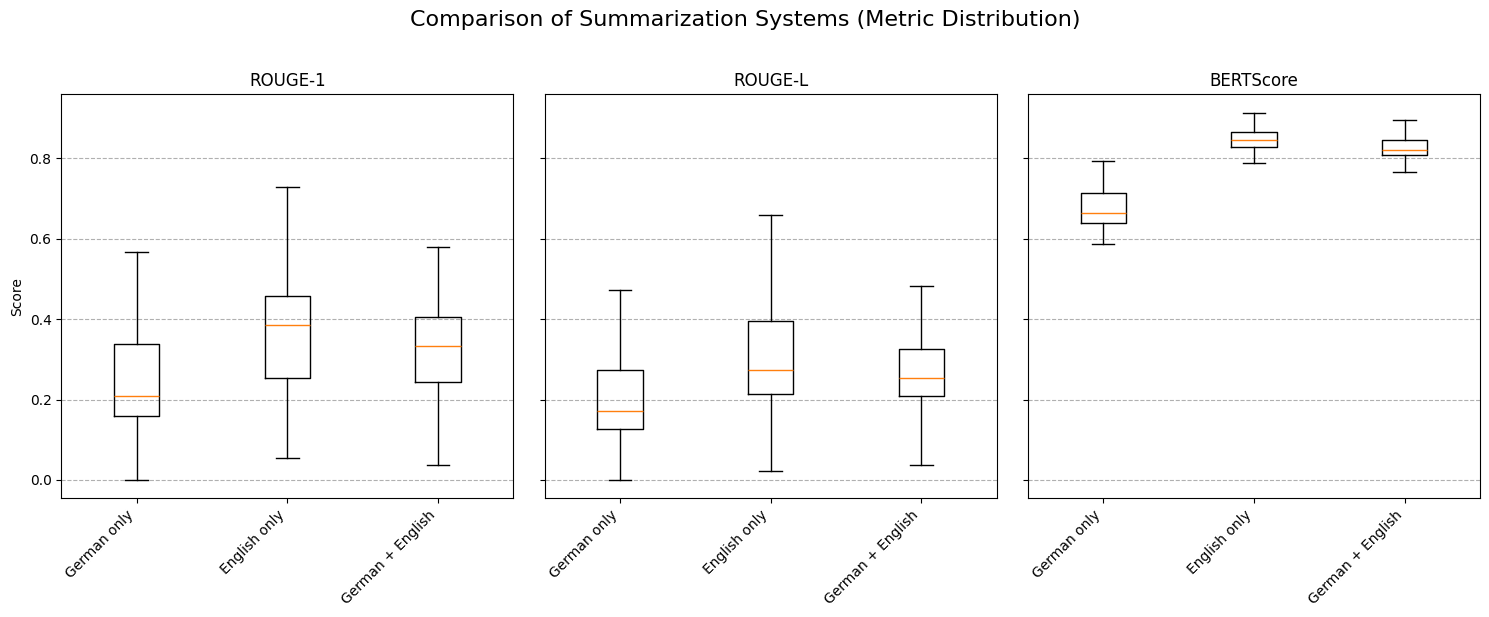

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from evaluate import load
import random

rouge = load("rouge")
bertscore = load("bertscore")

NUM_SAMPLES = 50


# Load the full datasets to use as references for evaluation
full_ds_de = load_dataset("joelniklaus/eurlex_resources", "de_caselaw", split="train")
full_ds_en = load_dataset("joelniklaus/eurlex_resources", "en_caselaw", split="train")

rouge1_de = []
rougeL_de = []
bert_f1_de = []

rouge1_en = []
rougeL_en = []
bert_f1_en = []

rouge1_multi = []
rougeL_multi = []
bert_f1_multi = []

print("\nComparision ")

if 'cases' not in globals():
    raise RuntimeError("`cases` dictionary not found – run the data loading and merging cell (q4MWb6D4TJ3M) first.")

if 'summarize_text' not in globals() or 'summarize_multilingual' not in globals():
     raise RuntimeError("Summarization functions (`summarize_text`, `summarize_multilingual`) not found – run the summarization pipeline cell (sJYl3CtUQZPG) first.")


# Filter cases that have both German and English
eval_cases = [(celex, data) for celex, data in cases.items() if data["de"] and data["en"]]
random.shuffle(eval_cases)
eval_cases = eval_cases[:NUM_SAMPLES]
if not eval_cases:
    print("No cases with both German and English texts found for evaluation.")
    # Exit here if no cases are found to avoid further errors
    exit()


print(f"Evaluating {len(eval_cases)} samples with both DE and EN texts.")

for i, (celex, case_data) in enumerate(eval_cases):

    text_de = case_data["de"]
    text_en = case_data["en"]

    print(f"\nSample {i+1} (CELEX: {celex}): DE length {len(text_de)}, EN length {len(text_en)}")


    #reference summaries (titles)
    reference_de_list = full_ds_de.filter(lambda x: x["celex"] == celex)["title"]
    reference_de = reference_de_list[0] if reference_de_list else ""

    reference_en_list = full_ds_en.filter(lambda x: x["celex"] == celex)["title"]
    reference_en = reference_en_list[0] if reference_en_list else ""

    reference_multi = f"DE: {reference_de} EN: {reference_en}"


    if not reference_de or len(reference_de.strip()) == 0:
        reference_de = "(Empty reference)"
        print("Warning: German reference summary is empty.")
    if not reference_en or len(reference_en.strip()) == 0:
        reference_en = "(Empty reference)"
        print("Warning: English reference summary is empty.")
    if not reference_multi or len(reference_multi.strip()) == 0:
        reference_multi = "(Empty reference)"
        print("Warning: Multilingual reference summary is empty.")


    try:
        summary_de = summarize_text(text_de)
        summary_en = summarize_text(text_en)
        summary_multi = summarize_multilingual(text_de, text_en)
    except Exception as e:
        print(f"Summarization failed for sample {i+1}: {e}")

        continue


    if reference_de != "(Empty reference)" and summary_de and not summary_de.startswith("(Summarization failed"):
        rouge_res_de = rouge.compute(predictions=[summary_de], references=[reference_de], use_stemmer=True)

        bert_res_de = bertscore.compute(predictions=[summary_de], references=[reference_de], lang="de", batch_size=8, device="cpu")
        rouge1_de.append(rouge_res_de["rouge1"])
        rougeL_de.append(rouge_res_de["rougeL"])
        bert_f1_de.append(bert_res_de["f1"][0])
        print(f"DE   ROUGE-1={rouge_res_de['rouge1']:.3f}  ROUGE-L={rouge_res_de['rougeL']:.3f}  BERT-F1={bert_res_de['f1'][0]:.3f}")
    else:
         print(f"Skipping DE-only evaluation for sample {i+1} due to missing reference or failed summarization.")


    print("Evaluating EN-only vs EN reference...")
    if reference_en != "(Empty reference)" and summary_en and not summary_en.startswith("(Summarization failed"):
        rouge_res_en = rouge.compute(predictions=[summary_en], references=[reference_en], use_stemmer=True)
        bert_res_en = bertscore.compute(predictions=[summary_en], references=[reference_en], lang="en", batch_size=8, device="cpu")
        rouge1_en.append(rouge_res_en["rouge1"])
        rougeL_en.append(rouge_res_en["rougeL"])
        bert_f1_en.append(bert_res_en["f1"][0])
        print(f"EN   ROUGE-1={rouge_res_en['rouge1']:.3f}  ROUGE-L={rouge_res_en['rougeL']:.3f}  BERT-F1={bert_res_en['f1'][0]:.3f}")
    else:
        print(f"Skipping EN-only evaluation for sample {i+1} due to missing reference or failed summarization.")


    print("Evaluating MULTI vs Combined Multi reference...")
    if reference_multi != "(Empty reference)" and summary_multi and not summary_multi.startswith("(Multilingual summarization failed"):
        rouge_res_multi = rouge.compute(predictions=[summary_multi], references=[reference_multi], use_stemmer=True)

        bert_res_multi = bertscore.compute(predictions=[summary_multi], references=[reference_multi], lang="en", batch_size=8, device="cpu")
        rouge1_multi.append(rouge_res_multi["rouge1"])
        rougeL_multi.append(rouge_res_multi["rougeL"])
        bert_f1_multi.append(bert_res_multi["f1"][0])
        print(f"MULTI (vs Combined Ref) ROUGE-1={rouge_res_multi['rouge1']:.3f}  ROUGE-L={rouge_res_multi['rougeL']:.3f}  BERT-F1={bert_f1_multi[-1]:.3f}")
    else:
        print(f"Skipping MULTI vs Combined Multi reference evaluation due to missing combined multi reference or failed multilingual summarization.")


# boxplots
metrics_data = {
    'ROUGE-1': [rouge1_de, rouge1_en, rouge1_multi],
    'ROUGE-L': [rougeL_de, rougeL_en, rougeL_multi],
    'BERTScore': [bert_f1_de, bert_f1_en, bert_f1_multi]
}

systems = ['German only', 'English only', 'German + English']
metric_names = ['ROUGE-1', 'ROUGE-L', 'BERTScore']

fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)

for i, metric in enumerate(metric_names):
    ax = axes[i]
    data_to_plot = metrics_data[metric]
    ax.boxplot(data_to_plot, showfliers=False)
    ax.set_title(metric)
    ax.set_xticks([1, 2, 3])
    ax.set_xticklabels(systems, rotation=45, ha="right")
    ax.grid(axis='y', linestyle='--')

axes[0].set_ylabel('Score')
fig.suptitle('Comparison of Summarization Systems (Metric Distribution)', y=1.02, fontsize=16)
fig.tight_layout()
plt.show()

In [ ]:

avg_rouge1_de = np.mean(rouge1_de) if rouge1_de else 0
avg_rougeL_de = np.mean(rougeL_de) if rougeL_de else 0
avg_bert_f1_de = np.mean(bert_f1_de) if bert_f1_de else 0

avg_rouge1_en = np.mean(rouge1_en) if rouge1_en else 0
avg_rougeL_en = np.mean(rougeL_en) if rougeL_en else 0
avg_bert_f1_en = np.mean(bert_f1_en) if bert_f1_en else 0

avg_rouge1_multi = np.mean(rouge1_multi) if rouge1_multi else 0
avg_rougeL_multi = np.mean(rougeL_multi) if rougeL_multi else 0
avg_bert_f1_multi = np.mean(bert_f1_multi) if bert_f1_multi else 0

data = {
    'System': ['German only', 'English only', 'German + English'],
    'ROUGE-1 (Mean)': [avg_rouge1_de, avg_rouge1_en, avg_rouge1_multi],
    'ROUGE-L (Mean)': [avg_rougeL_de, avg_rougeL_en, avg_rougeL_multi],
    'BERTScore F1 (Mean)': [avg_bert_f1_de, avg_bert_f1_en, avg_bert_f1_multi]
}

df_metrics = pd.DataFrame(data)

print("\nAverage Evaluation Metrics:")
display(df_metrics)


Average Evaluation Metrics:


,System,ROUGE-1 (Mean),ROUGE-L (Mean),BERTScore F1 (Mean)
0,German only,0.259779,0.202091,0.681188
1,English only,0.366463,0.296455,0.848721
2,German + English,0.332152,0.266536,0.828051
